# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# Experimentation - the fun part
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


#### In this document:
* we test the functions from pj_funcs.py
* we explore showing message errors using excel
* visualize completion/validity
* Explore yourself!

In [1]:
# Import all of my neat functions.
from pj_funcs import *

# Import data that we will play with
data = pd.read_csv('../data/raw/export.csv', encoding = 'Cp1252')

# -Test our primary functions from pj_funcs.py

### timeliness_facvisits_hours( data , Timed=False )

A report describing the percent of a facility's visits that had messages sent within 24 hours, between 24-48 hours, and 48+ hours.

In [2]:
# Make Timeliness Report
timeliness_report = timeliness_facvisits_hours(data)

C:\Users\PGibson\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### NSSP_Element_Grabber( data , Timed=True , Priority_only=False , outfile='None' )

Dataframe of NSSP Priority Elements (with supporting elements/data sources) defined column-wise alongside the respective MESSAGE, Patient_MRN, and Patient_Visit_Number.

#### \* Biased Opinion:  THIS IS THE MOST IMPORTANT FUNCTION

In [3]:
####################################################################
# Creating NSSP Element dataframe, the most important function.
####################################################################

df = NSSP_Element_Grabber(data)

52.36926817893982


### priority_cols( df , priority='both' , extras=None , drop_cols=None )

Takes only priority columns from a dataframe.  Allows you to keep columns from the original input dataframe or remove columns from the output.

In [4]:
# For later indexing, it is useful to have the message,patMRN,patVisitNum,Fac_Name
# Site_ID and C_Facility_ID are NSSP system-generated so we don't have values for them.  They're all null/missing

df_main = priority_cols(df,extras=['MESSAGE','PATIENT_MRN','PATIENT_VISIT_NUMBER','FACILITY_NAME'],
                    drop_cols=['Site_ID','C_Facility_ID'])

### completeness_facvisits( df , Timed=False )

A report describing the percent of a facility's visits that had non-missing values for each column in the input dataframe.  Typically we only care about the the completeness of the NSSP Priority Elements, so it is often used in conjunction with the <b>priority_cols()</b> function.

In [5]:
# Make Completeness Report
completeness = completeness_facvisits(df_main)

completeness_report = priority_cols(completeness)

C:\Users\PGibson\Documents\HL7_Parsing\python\pj_funcs.py:179: RuntimeWarning: invalid value encountered in true_divide
  empty.loc[facility,:] = (countz/visit_count)*100


### issues_in_messages( df, Timed=True, combine_issues_on_message=False , split_issue_column=False )

A dataframe with information about the message, visit, and associated issues withe the message.

In [6]:
# Find issues in messages
message_issues = issues_in_messages(df_main)

C:\Users\PGibson\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Time Elapsed:   3.114 seconds


# -Displaying Message Issues in Excel

### Excel Output Version 1

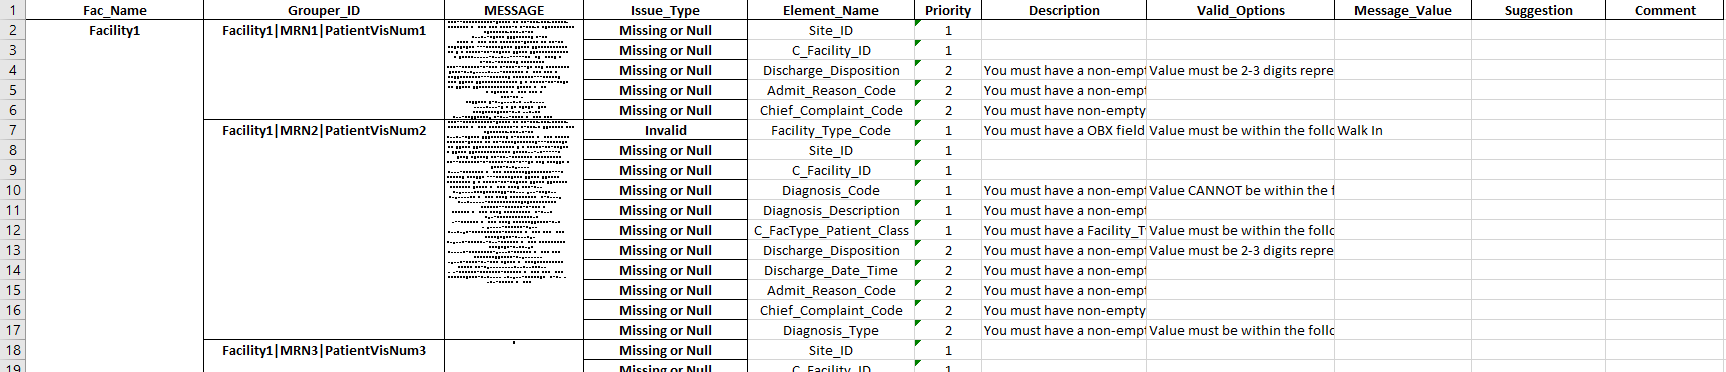

In this case, the invalid values were unique enough to be processed without any suggestion/comment for correction.  Note that these cases represent less than 4% of invalid values.


\* Also note to get this exact appearance, I formatted display settings in the excel spreadsheet to prevent text overflow (to make it pretty)


In [104]:
# Find issues in messages
split_by_issue = issues_in_messages(df, split_issue_column=True)

# Maybe you only want to look at errors related to specifically priority 1 (or 2) elements
#split_by_issue = split_by_issue[split_by_issue.Priority=='1']
#split_by_issue = split_by_issue[split_by_issue.Priority=='2']

# Get the facility name from the grouper ID
split_by_issue['Fac_Name'] = split_by_issue.Grouper_ID.str.split('\|').str[0]

# First sort the values so that all facility rows are next to one another, then by message similarly
split_by_issue = split_by_issue.sort_values(['Fac_Name','Grouper_ID','MESSAGE','Priority'])

# Set the indices so that when we export to excel, the index cells will merge making it look pretty
split_by_issue = split_by_issue.set_index(['Fac_Name','Grouper_ID','MESSAGE','Issue_Type'])

# Send it to an excel file!
split_by_issue.to_excel('../data/processed/split_by_issue.xlsx')

C:\Users\PGibson\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Time Elapsed:   6.554 seconds


### Excel Output Version 2

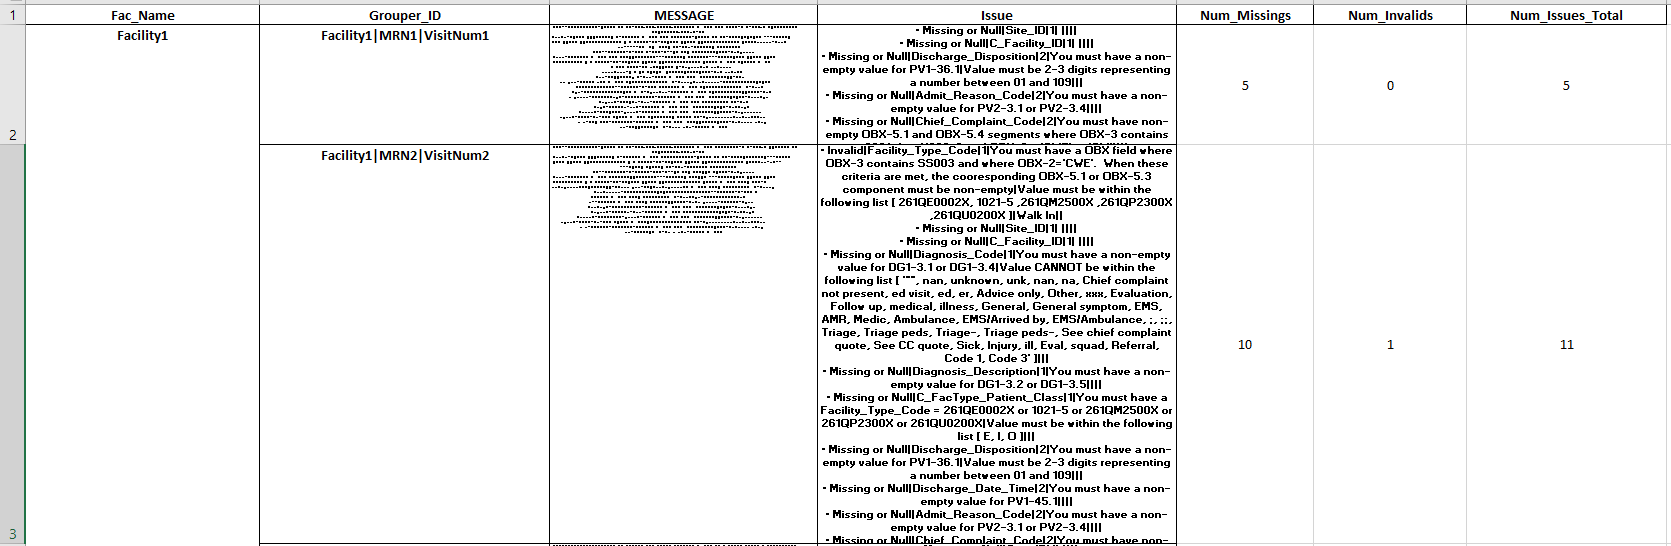


In [105]:
# Find issues in messages
comb_issues = issues_in_messages(df, combine_issues_on_message=True)

# Get the facility name
comb_issues['Fac_Name'] = comb_issues.Grouper_ID.str.split('\|').str[0]

# Make first issue start with bullet point
comb_issues['Issue'] = comb_issues['Issue'].str.replace('^(.*)','• \g<1>',regex=True)

# Make each new line have a bullet point.
comb_issues['Issue'] = comb_issues['Issue'].str.replace('\n','\n• ')

# First sort the values so that all facility rows are next to one another, then by message similarly
comb_issues = comb_issues.sort_values(['Fac_Name','Grouper_ID','MESSAGE'])

# Set the indices so that when we export to excel, the index cells will merge making it look pretty
comb_issues = comb_issues.set_index(['Fac_Name','Grouper_ID','MESSAGE','Issue'])


# Send it to an excel file!
comb_issues.to_excel('../data/processed/comb_issue.xlsx')

C:\Users\PGibson\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Time Elapsed:   10.708 seconds


# - Visualize Completion / Validity

### Heatmap of NSSP Element completion percentages by Facility

In [41]:
# Create heatmap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# Get the completeness report 
df_comp = completeness_facvisits(df_main)

# Replace NA with 0, sort by the overall sum of completion percentages.
#     Do this because this sum gives us a general idea for how good data quality was.
df_comp = df_comp.fillna(0)
df_comp['a_bsum'] = df_comp.sum(axis=1)
df_comp = df_comp.sort_values('a_bsum',ascending=True).drop('a_bsum',axis=1)

C:\Users\PGibson\Documents\HL7_Parsing\python\pj_funcs.py:179: RuntimeWarning: invalid value encountered in true_divide
  empty.loc[facility,:] = (countz/visit_count)*100


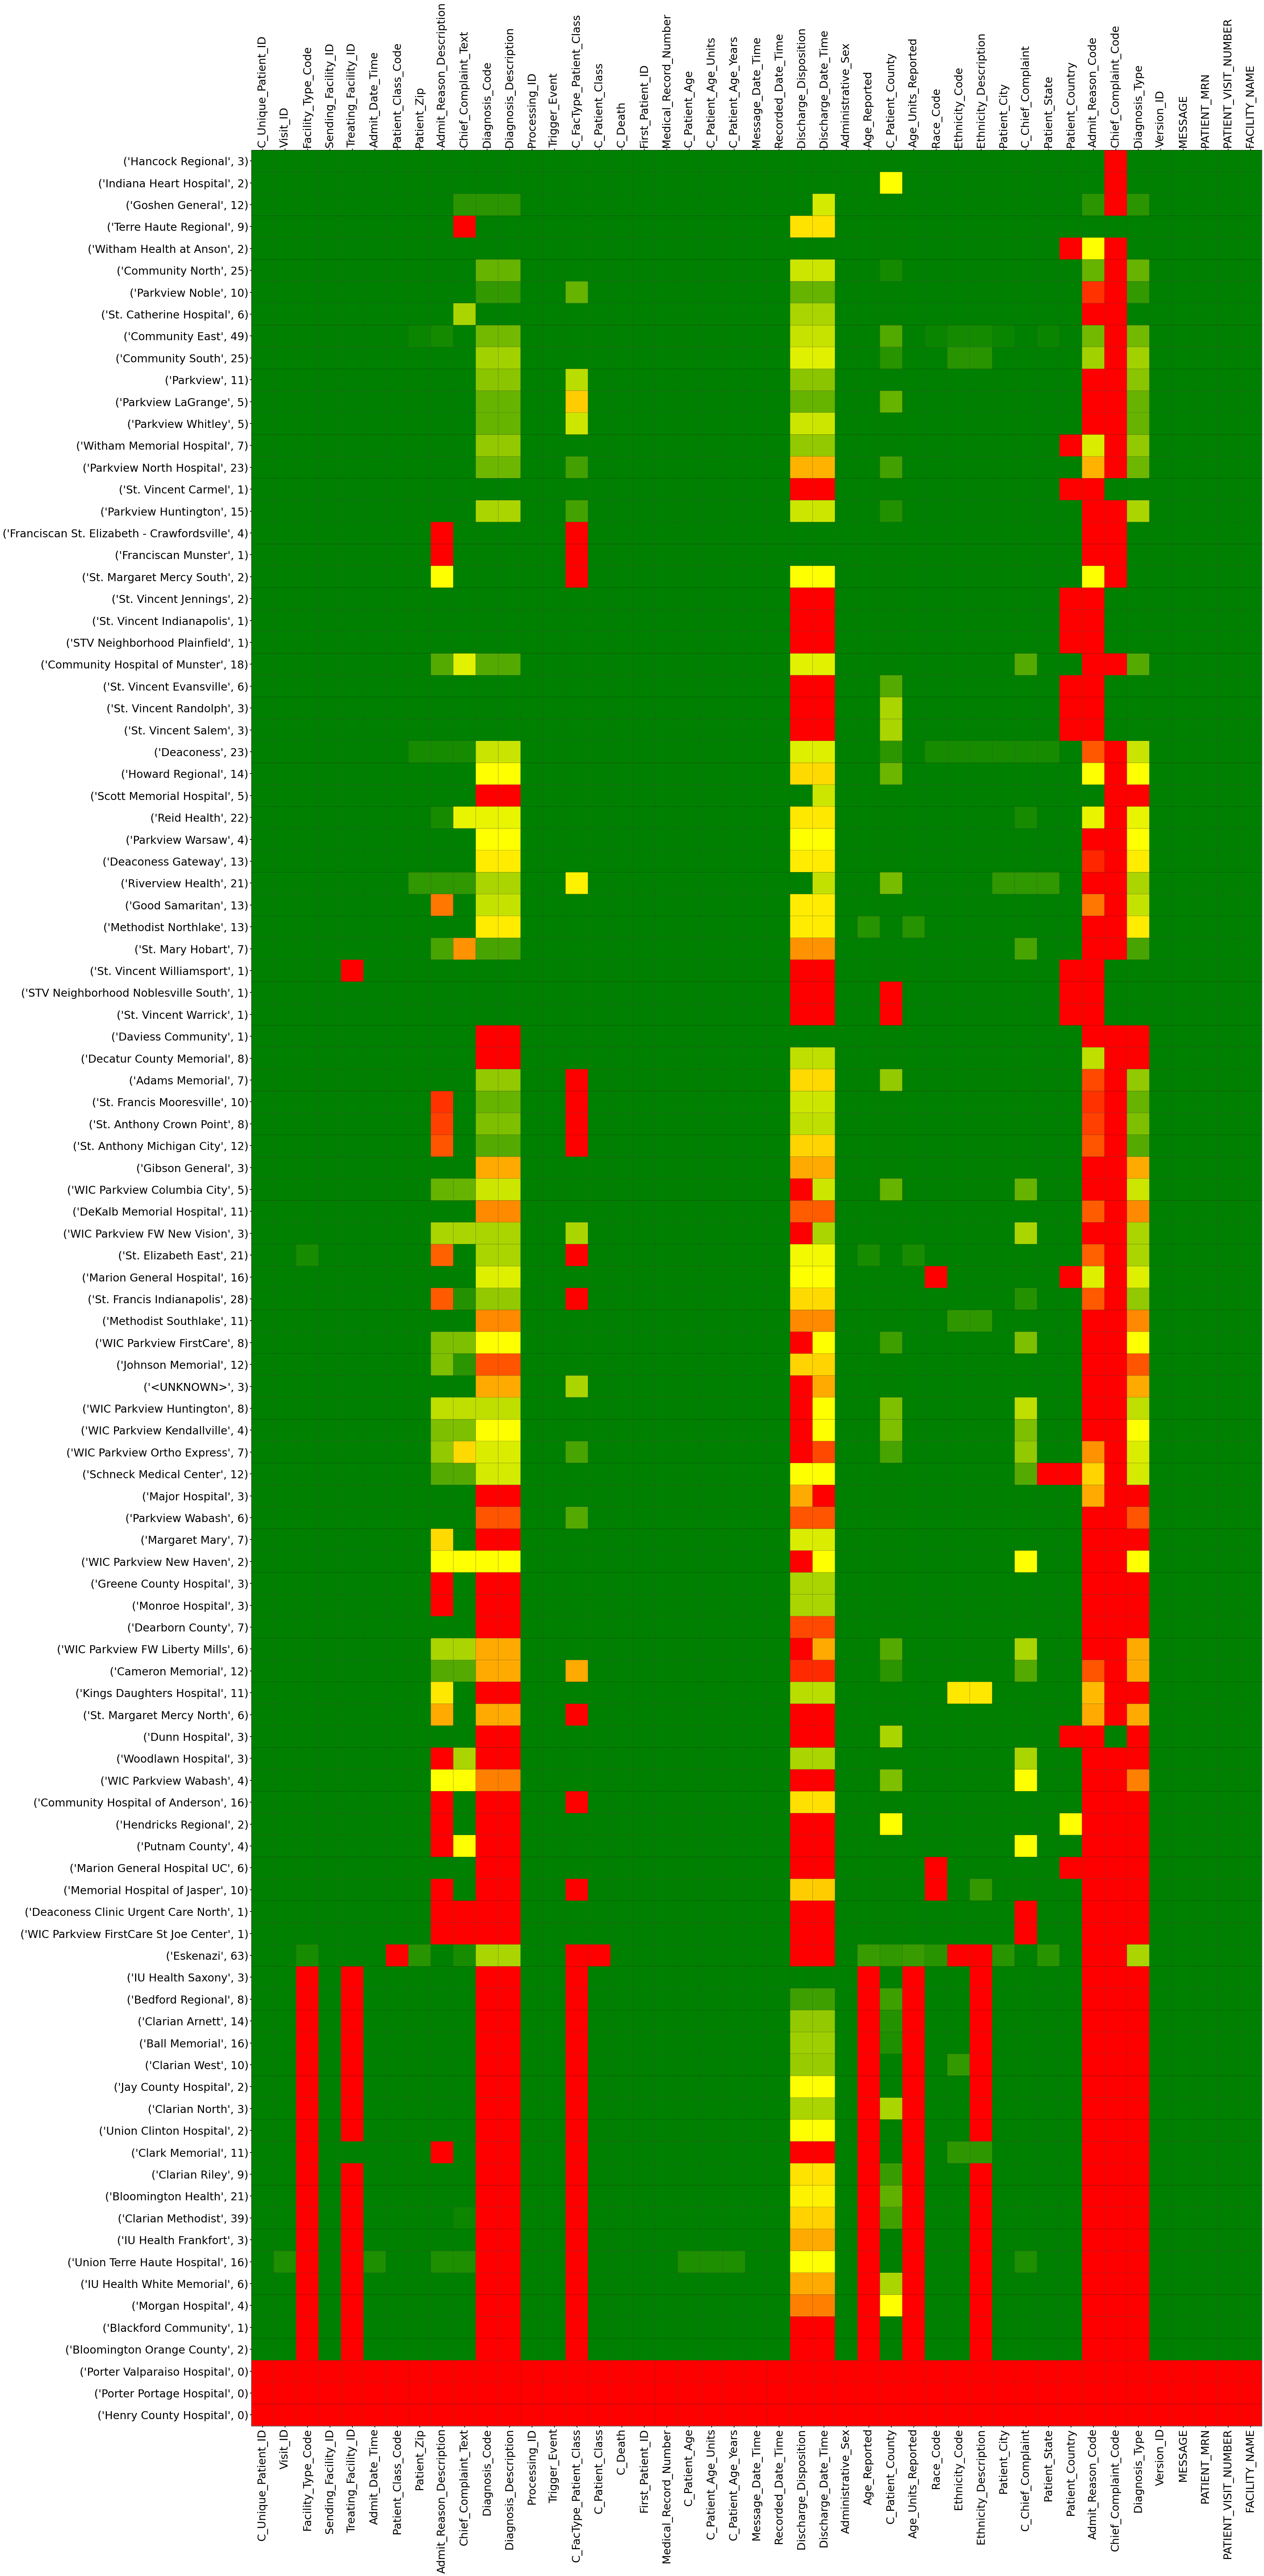

In [42]:
# Make a nice figure with square heatmap boxes.
fig = plt.figure(figsize=(50,50*(len(df_comp) / len(df_comp.columns))))
ax = fig.add_subplot( 111 )

# Produce the heatmap using pcolor (compatible with pandas)
ax.pcolor(df_comp,cmap=cmap,edgecolors='k')

# Set the x/y ticks.
plt.yticks(np.arange(0.5, len(df_comp.index), 1), df_comp.index)
plt.xticks(np.arange(0.5, len(df_comp.columns), 1), df_comp.columns,rotation=90)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True,
              length=4,width=2)

# Specify y tick length and width
ax.tick_params(axis='y', length=4,width=2)

# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=90,
         ha="left", va="center",rotation_mode="anchor")

# Change size of xtick, ytick labels
ax.tick_params(axis='both', which='major', labelsize=30)


plt.show()

### See if overall data completion is related to number of visits

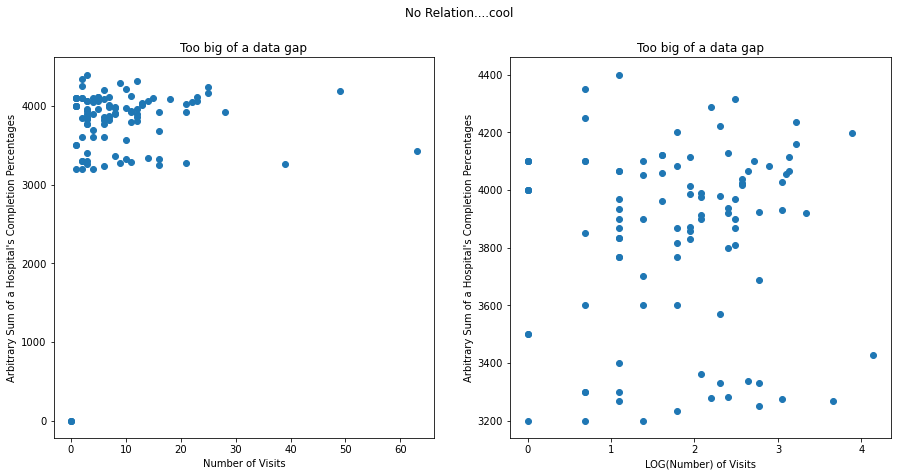

In [32]:
# Look at the number of vists (x) against the overall sum of completion percentages (y)

x = np.array(df_comp.index.to_frame().Num_Visits)
y = np.array(df_comp.sum(axis=1))

fig = plt.figure(figsize=(15,7))

plt.suptitle('No Relation....cool')

ax = fig.add_subplot(1,2,1)
ax.set_title('Too big of a data gap')
ax.scatter(x,y)
ax.set_xlabel('Number of Visits')
ax.set_ylabel('Arbitrary Sum of a Hospital\'s Completion Percentages')


ax2= fig.add_subplot(1,2,2)
ax2.set_title('Too big of a data gap')
ax2.scatter(np.log(x[3:]),y[3:])
ax2.set_xlabel('LOG(Number) of Visits')
ax2.set_ylabel('Arbitrary Sum of a Hospital\'s Completion Percentages')

plt.show()

### Plot number of message issues (for facilities) by issue_type

In [165]:
# Find issues in messages
comb_issues = issues_in_messages(df_main, combine_issues_on_message=True)

# Get the facility name
comb_issues['Fac_Name'] = comb_issues.Grouper_ID.str.split('\|').str[0]

C:\Users\PGibson\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Time Elapsed:   4.663 seconds


In [167]:
# Group our issue data by facility name
factz = comb_issues.groupby('Fac_Name')

# Intitialize some empty lists to append to
xs = []
y1s = []
y2s = []

# Loop through our groupby object and append facname, avg missing per message, avg invalid per message
for index, frame in factz:
    xs.append(index)
    y1s.append(frame.Num_Missings.sum()/len(frame))
    y2s.append(frame.Num_Invalids.sum()/len(frame))
    
    
# Make into numpy arrays because everything is better that way.
xs = np.array(xs)
y1s = np.array(y1s)
y2s = np.array(y2s)

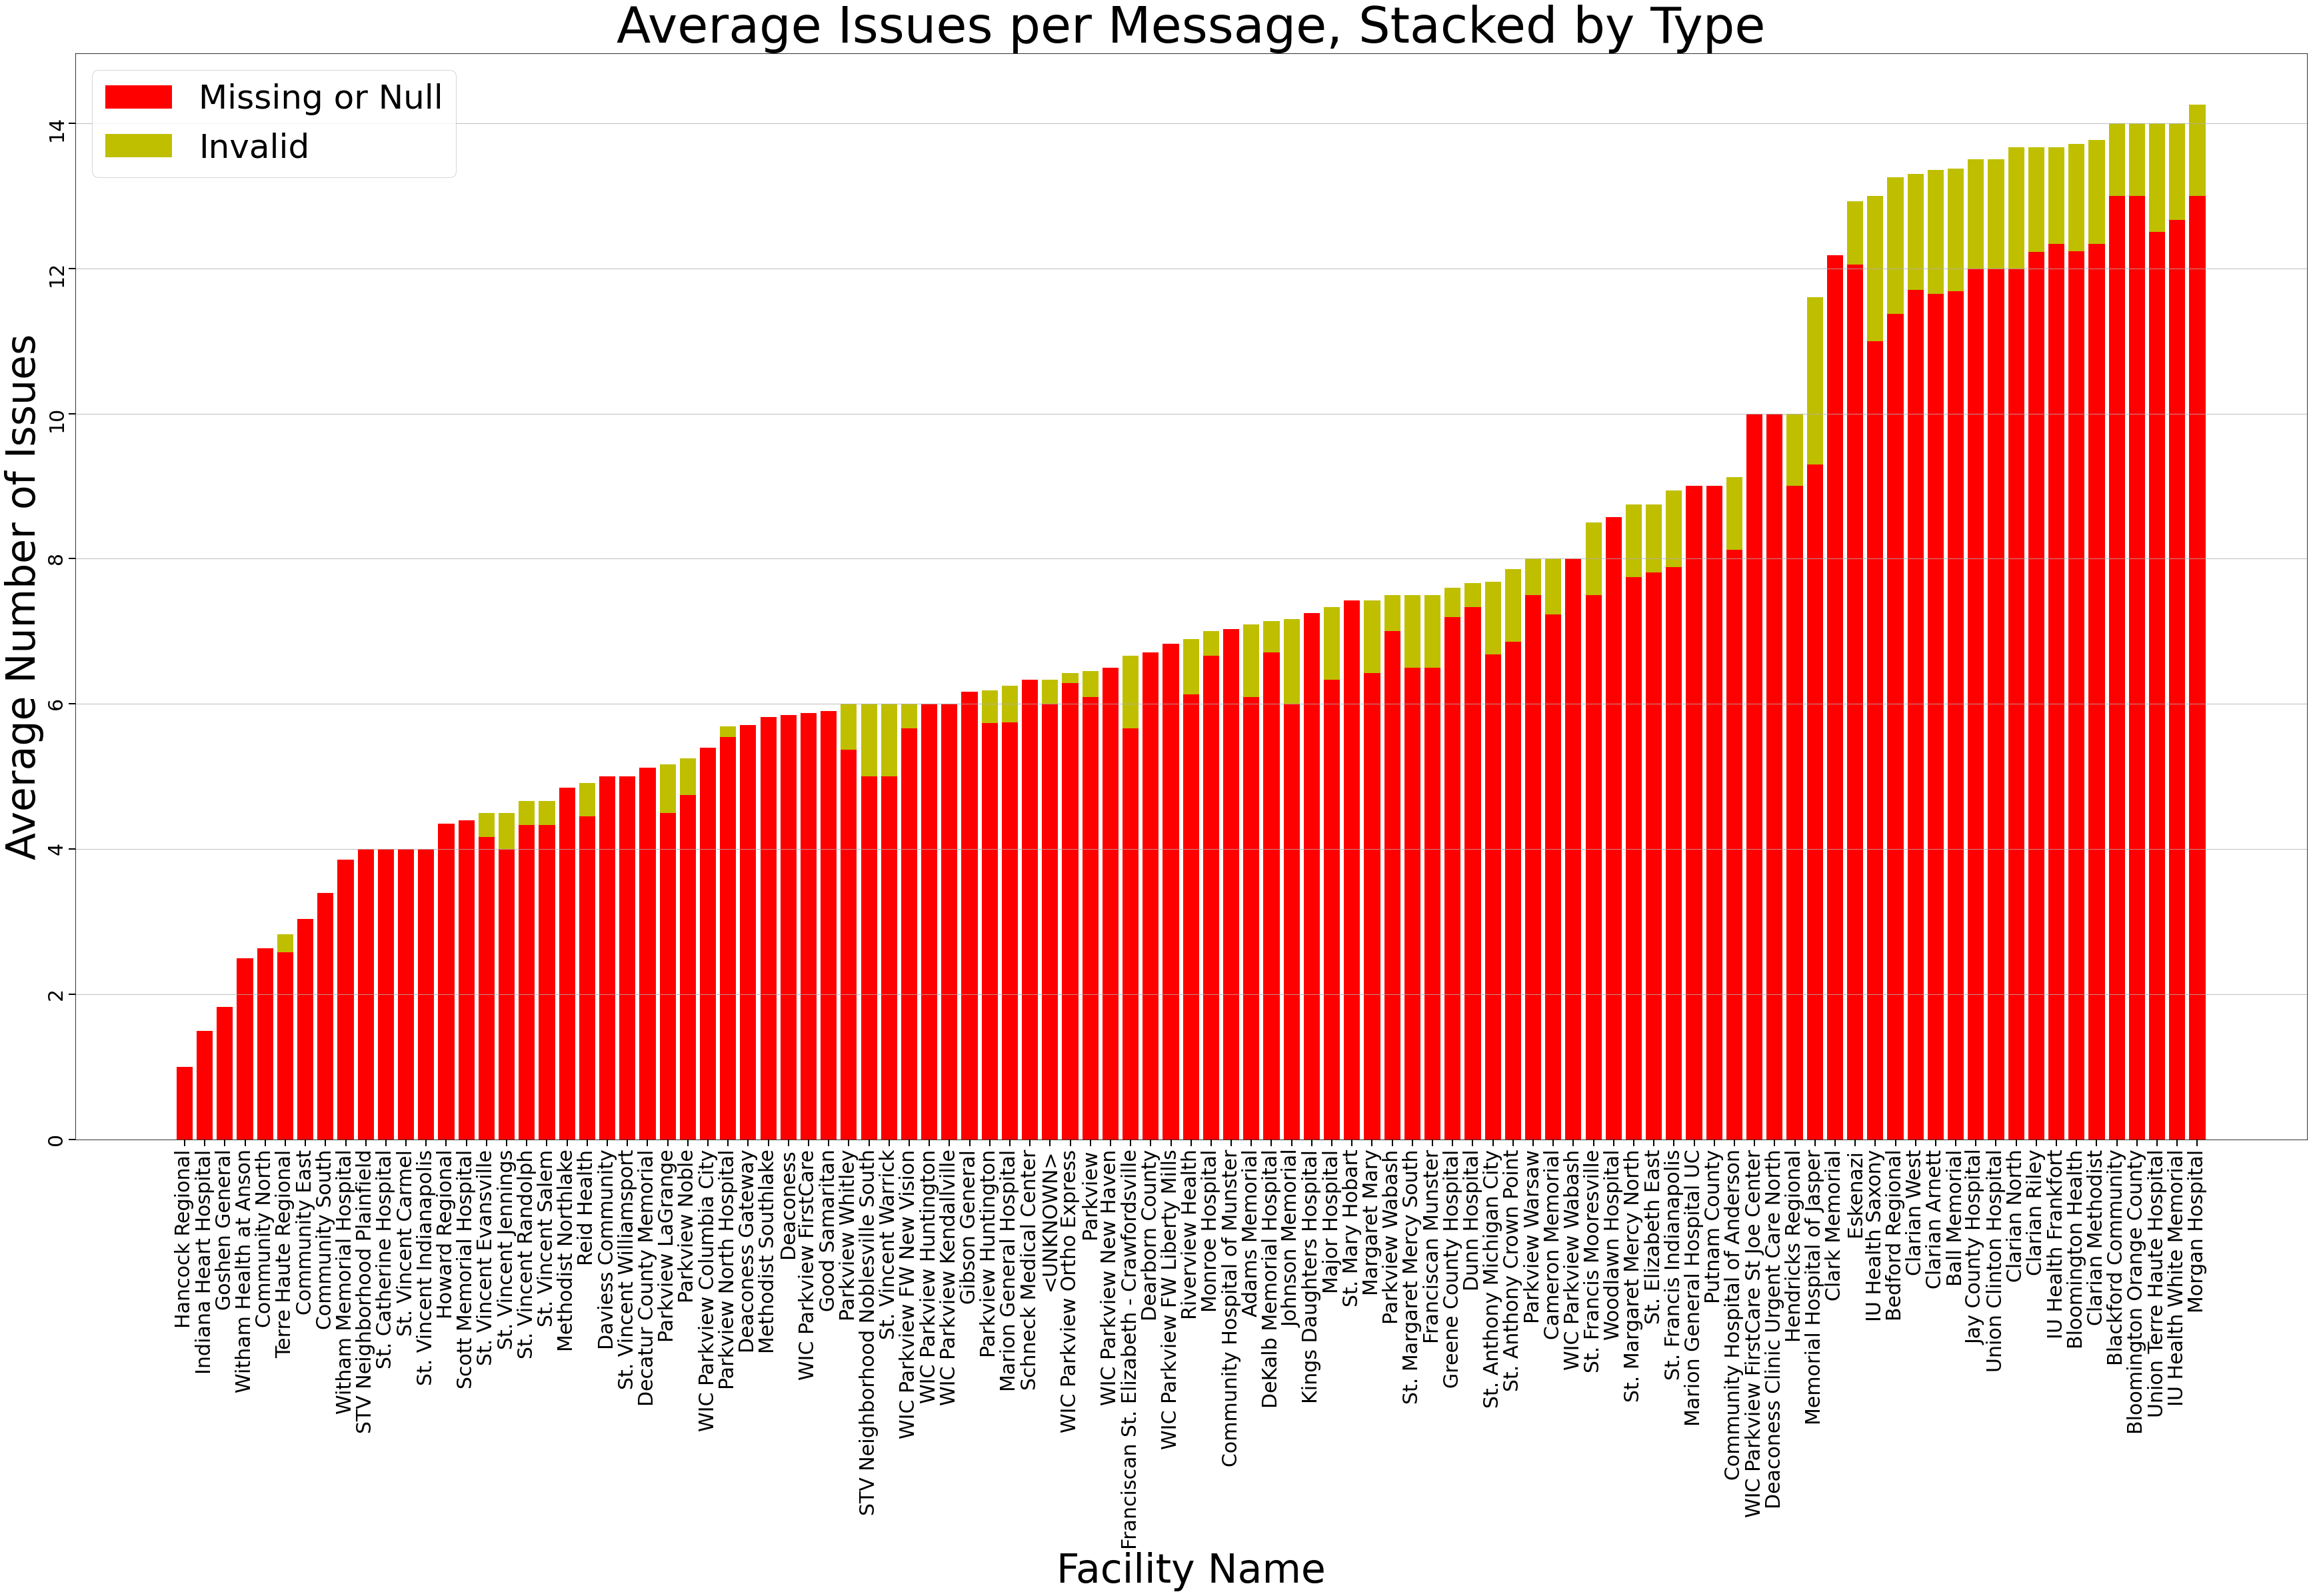

In [176]:
# Find total average errors and find the indeces of this array sorted 
# NOTE:  the only reason I sort is to make output easier to read.  You can see below.
tots = y1s + y2s
argz = tots.argsort()

# Create a list of 0-len(xs) to be x values in plot.  Keep our facnames as the xticklabels (sorted)
x = np.arange(0,len(xs))
xlabels = xs[argz]

# define our sorted y values for our plot.
y1 = y1s[argz]
y2 = y2s[argz]

# Make figure.  Create 1 subplot and define width of our columns
fig = plt.figure(figsize=(60,30))
ax = fig.add_subplot(111)
width = 0.8

# Make bar plot of avg num of missing/nulls. Alpha means it is non-transparent
p1 = ax.bar(x,y1,width,color='r',alpha=1)

# Stack the avg num of invalids on top by specifying 'bottom='
p2 = ax.bar(x,y2,width,color='y',bottom=y1,alpha=1)

# Set location of x ticks and label them
ax.set_xticks(x)
ax.set_xticklabels(xlabels)

# Create title, legend, xlabel, ylabel 
plt.title('Average Issues per Message, Stacked by Type',fontsize=75)
plt.legend((p1[0], p2[0]), ('Missing or Null', 'Invalid'),fontsize=50)
plt.xlabel('Facility Name',fontsize=60)
plt.ylabel('Average Number of Issues',fontsize=60)

# Change size of xtick, ytick labels
ax.tick_params(axis='both', which='major', labelsize=30,rotation=90,length=10,width=2)

# Make there be y-grid lines.
ax.yaxis.grid(True)

# Show the output
plt.show()

# Explore yourself!

### I would recommend using some of the following functions to start things off.

* NSSP_Element_Grabber(data, Timed=True, Priority_only=False, outfile='None')
* timeliness_facvisits_hours(data, Timed=False)
* priority_cols(df, priority='both', extras=None, drop_cols=None)
* completeness_facvisits(df, Timed=False)
* issues_in_messages(
    df,
    Timed=True,
    combine_issues_on_message=False,
    split_issue_column=False
)
* Visualize_Facility_DQ(df, fac_name, hide_yticks=False, Timed=True)

In [ ]:
data = pd.read_csv('../data/raw/YOURFILENAME.csv', encoding = 'Cp1252')

In [ ]:
# Begin!